Zbuduj sieć opartą na rekurencyjnych sieciach neuronowych do prognozowania kursu otwarcia akcji (jeden dzień naprzód) .

Dostęp do danych finansowych - biblioteka yfinance. 

 Dane uczące:/ walidujące 3 lata (2020-2022) 
Podziel dane na ciąg trenujący i walidujący w proporcjach 70:30.
Oceń jakość modelu 
 Zwizualizuj rzeczywisty i prognozowany kurs otwarcia dla roku 2023
Zrealizuj zadanie w wariancie:

"vanilla RNN" - najprostsza sieć RNN złożona z 20 unitów 
dwuwarstwowej LSTM, złozonej z 20 unitów. 

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Parametry
TICKER = 'AAPL'
START = '2020-01-01'
END = '2023-12-31'

# Pobierz dane
raw_data = yf.download(TICKER, start=START, end=END)
data = raw_data[['Open']].copy()

# Podział na lata
train_val = data.loc['2020-01-01':'2022-12-31']
test = data.loc['2023-01-01':'2023-12-31']

# Normalizacja
scaler = MinMaxScaler()
train_val_scaled = scaler.fit_transform(train_val)
test_scaled = scaler.transform(test)

# Podział train/val 70:30
split = int(len(train_val_scaled) * 0.7)
train_scaled = train_val_scaled[:split]
val_scaled = train_val_scaled[split:]

# Funkcja do tworzenia sekwencji

def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 10
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_val, y_val = create_sequences(val_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')

/tmp/ipykernel_5231/193603108.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed

Train: (519, 10, 1), Val: (217, 10, 1), Test: (240, 10, 1)


Epoch 5/30, Val Loss: 0.029677
Epoch 10/30, Val Loss: 0.002228
Epoch 10/30, Val Loss: 0.002228
Epoch 15/30, Val Loss: 0.001974
Epoch 15/30, Val Loss: 0.001974
Epoch 20/30, Val Loss: 0.001821
Epoch 20/30, Val Loss: 0.001821
Epoch 25/30, Val Loss: 0.001690
Epoch 25/30, Val Loss: 0.001690
Epoch 30/30, Val Loss: 0.001611
Test MSE (Vanilla RNN): 51.60
Epoch 30/30, Val Loss: 0.001611
Test MSE (Vanilla RNN): 51.60


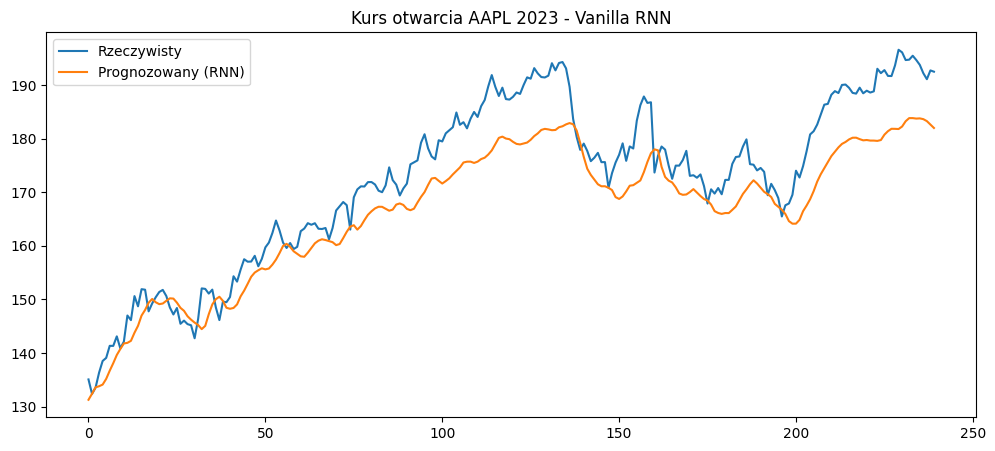

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Przygotowanie danych do PyTorch
def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_t = to_tensor(X_train)
y_train_t = to_tensor(y_train)
X_val_t = to_tensor(X_val)
y_val_t = to_tensor(y_val)
X_test_t = to_tensor(X_test)
y_test_t = to_tensor(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Vanilla RNN
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)

# Trening
rnn = VanillaRNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

EPOCHS = 30
for epoch in range(EPOCHS):
    rnn.train()
    for xb, yb in train_loader:
        xb = xb.view(xb.size(0), xb.size(1), 1)
        pred = rnn(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Walidacja
    rnn.eval()
    with torch.no_grad():
        val_preds = rnn(X_val_t.view(X_val_t.size(0), X_val_t.size(1), 1)).squeeze()
        val_loss = loss_fn(val_preds, y_val_t.squeeze())
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Val Loss: {val_loss.item():.6f}")

# Ocena na testowym
rnn.eval()
with torch.no_grad():
    test_preds = rnn(X_test_t.view(X_test_t.size(0), X_test_t.size(1), 1)).squeeze().numpy()
    test_preds_inv = scaler.inverse_transform(test_preds.reshape(-1,1)).flatten()
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    mse = np.mean((test_preds_inv - y_test_inv)**2)
    print(f"Test MSE (Vanilla RNN): {mse:.2f}")

# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Rzeczywisty')
plt.plot(test_preds_inv, label='Prognozowany (RNN)')
plt.title('Kurs otwarcia AAPL 2023 - Vanilla RNN')
plt.legend()
plt.show()

[LSTM] Epoch 5/30, Val Loss: 0.019662
[LSTM] Epoch 10/30, Val Loss: 0.002935
[LSTM] Epoch 10/30, Val Loss: 0.002935
[LSTM] Epoch 15/30, Val Loss: 0.003130
[LSTM] Epoch 15/30, Val Loss: 0.003130
[LSTM] Epoch 20/30, Val Loss: 0.003160
[LSTM] Epoch 20/30, Val Loss: 0.003160
[LSTM] Epoch 25/30, Val Loss: 0.002491
[LSTM] Epoch 25/30, Val Loss: 0.002491
[LSTM] Epoch 30/30, Val Loss: 0.003045
Test MSE (LSTM): 37.06
[LSTM] Epoch 30/30, Val Loss: 0.003045
Test MSE (LSTM): 37.06


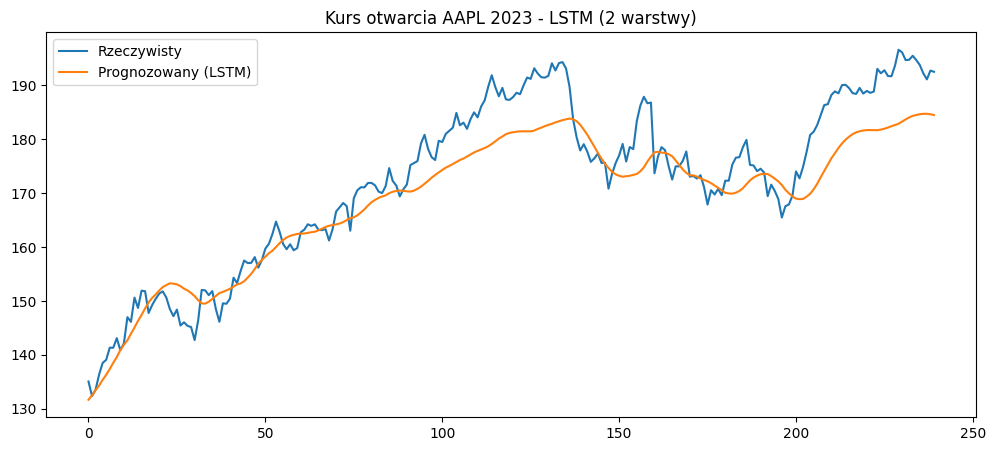

In [3]:
# Dwuwarstwowa LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

lstm = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

EPOCHS = 30
for epoch in range(EPOCHS):
    lstm.train()
    for xb, yb in train_loader:
        xb = xb.view(xb.size(0), xb.size(1), 1)
        pred = lstm(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Walidacja
    lstm.eval()
    with torch.no_grad():
        val_preds = lstm(X_val_t.view(X_val_t.size(0), X_val_t.size(1), 1)).squeeze()
        val_loss = loss_fn(val_preds, y_val_t.squeeze())
    if (epoch+1) % 5 == 0:
        print(f"[LSTM] Epoch {epoch+1}/{EPOCHS}, Val Loss: {val_loss.item():.6f}")

# Ocena na testowym
lstm.eval()
with torch.no_grad():
    test_preds_lstm = lstm(X_test_t.view(X_test_t.size(0), X_test_t.size(1), 1)).squeeze().numpy()
    test_preds_lstm_inv = scaler.inverse_transform(test_preds_lstm.reshape(-1,1)).flatten()
    mse_lstm = np.mean((test_preds_lstm_inv - y_test_inv)**2)
    print(f"Test MSE (LSTM): {mse_lstm:.2f}")

# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Rzeczywisty')
plt.plot(test_preds_lstm_inv, label='Prognozowany (LSTM)')
plt.title('Kurs otwarcia AAPL 2023 - LSTM (2 warstwy)')
plt.legend()
plt.show()